## 1. Make a binary classification dataset with Scikit-Learn's `make_moons()` function.
* For consistency, dataset should have **1000** samples and a `random_seed=42`.
* Turn the data into PyTorch tensors, splitting it into test/train using `train_test_split` with 80% as training and 20% as test.

In [1]:
import torch
from sklearn import datasets
from sklearn.model_selection import train_test_split

N_SAMPLES = 1000
RANDOM_STATE = 42
TRAIN_SIZE = 0.8
TEST_SIZE = 0.2

In [2]:
# Create dataset with X and y
X, y = datasets.make_moons(
	n_samples=N_SAMPLES,
	shuffle=True,
	noise=0.1,
	random_state=RANDOM_STATE
)

X[:5], y[:5]

(array([[-0.05146968,  0.44419863],
        [ 1.03201691, -0.41974116],
        [ 0.86789186, -0.25482711],
        [ 0.288851  , -0.44866862],
        [-0.83343911,  0.53505665]]),
 array([1, 1, 1, 1, 0]))

In [3]:
# Turn X and y into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [4]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
													y, 
													test_size=TEST_SIZE,
													random_state=RANDOM_STATE)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

## 2. Build a model by subclassing `nn.Module` that incorporates non-linear activation functions and is capable of fitting data you've create in 1. Feel free to use any combination of PyTorch layers.

In [5]:
from torch import nn

device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'mps'

In [6]:
class ExerciseModel(nn.Module):
	def __init__(
			self,
			input_features: int = 2,
			output_features: int = 1,
			hidden_units: int = 16
			):
		super().__init__()

		# Architecture of the model: 3 Linear layers with non-linear activation functions between them
		self.layer1 = nn.Linear(in_features=input_features, out_features=hidden_units)
		self.layer2 = nn.ReLU()
		self.layer3 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
		self.layer4 = nn.ReLU()
		self.layer5 = nn.Linear(in_features=hidden_units, out_features=output_features)
		self.layer6 = nn.ReLU()

	def forward(self, x):
		return self.layer5(self.layer4(self.layer3(self.layer2(self.layer1(x)))))

In [7]:
model = ExerciseModel().to(device)
model

ExerciseModel(
  (layer1): Linear(in_features=2, out_features=16, bias=True)
  (layer2): ReLU()
  (layer3): Linear(in_features=16, out_features=16, bias=True)
  (layer4): ReLU()
  (layer5): Linear(in_features=16, out_features=1, bias=True)
  (layer6): ReLU()
)

## 3. Setup a binary classification compatibile loss function and optimizer to use when training the model.

In [8]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(
	params=model.parameters(),
	lr=0.01
	)

## 4. Setup a training and testing loop to fit the model created in 2. to the data from 1. 
* Measure the model accuracy - either use your own metric or use ones from `TorchMetrics`
* Train the model long enough to reach over 96% accuracy
* Training loop should output progress every 10 epochs (training and test loss, accuracy)

In [9]:
from torchmetrics.classification import BinaryAccuracy, Accuracy
from helper_functions import accuracy_fn

torchmetric_acc = BinaryAccuracy(threshold=0.5).to(device)

In [10]:
# Setup the randomness
torch.manual_seed(RANDOM_STATE)
torch.mps.manual_seed(RANDOM_STATE)

# Move tensors to 'device'
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

# Setup number of epochs - eyballed
EPOCHS = 300

for epoch in range(EPOCHS+1):
	### TRAINING
	model.train()

	# Forward pass
	y_logits = model(X_train).squeeze()
	y_preds = torch.round(torch.sigmoid(y_logits)) # logits -> pred probabilities -> pred labels

	# Loss/acc
	loss = loss_fn(y_logits, y_train)
	#acc = torchmetric_acc(y_preds, y_train)
	acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

	# Zero grad
	optimizer.zero_grad()

	# Backward pass
	loss.backward()

	# Step
	optimizer.step()

	### TESTING
	model.eval()
	with torch.inference_mode():
		test_logits = model(X_test).squeeze()
		test_preds = torch.round(torch.sigmoid(test_logits))

		test_loss = loss_fn(test_logits, y_test)
		#test_acc = torchmetric_acc(test_preds, y_test)
		test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)

	if epoch % 10 == 0:
			print(f"Epoch: {epoch} | Loss: {loss:.3f} | Acc: {acc:.2f}% | Test loss: {test_loss:.3f} | Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.677 | Acc: 80.50% | Test loss: 0.667 | Test acc: 76.00%
Epoch: 10 | Loss: 0.531 | Acc: 79.62% | Test loss: 0.528 | Test acc: 76.50%
Epoch: 20 | Loss: 0.345 | Acc: 83.12% | Test loss: 0.354 | Test acc: 82.00%
Epoch: 30 | Loss: 0.267 | Acc: 86.50% | Test loss: 0.262 | Test acc: 86.50%
Epoch: 40 | Loss: 0.240 | Acc: 88.88% | Test loss: 0.235 | Test acc: 88.50%
Epoch: 50 | Loss: 0.229 | Acc: 88.88% | Test loss: 0.224 | Test acc: 89.00%
Epoch: 60 | Loss: 0.220 | Acc: 89.25% | Test loss: 0.219 | Test acc: 89.00%
Epoch: 70 | Loss: 0.215 | Acc: 90.00% | Test loss: 0.217 | Test acc: 89.50%
Epoch: 80 | Loss: 0.211 | Acc: 90.38% | Test loss: 0.212 | Test acc: 90.00%
Epoch: 90 | Loss: 0.206 | Acc: 90.62% | Test loss: 0.208 | Test acc: 90.00%
Epoch: 100 | Loss: 0.199 | Acc: 90.88% | Test loss: 0.200 | Test acc: 90.00%
Epoch: 110 | Loss: 0.189 | Acc: 91.38% | Test loss: 0.189 | Test acc: 91.00%
Epoch: 120 | Loss: 0.173 | Acc: 92.38% | Test loss: 0.171 | Test acc: 92.50%
Epoch: 130

## 5. Make predictions with trained model and plot them using `plot_decision_boundary()` from the notebook.

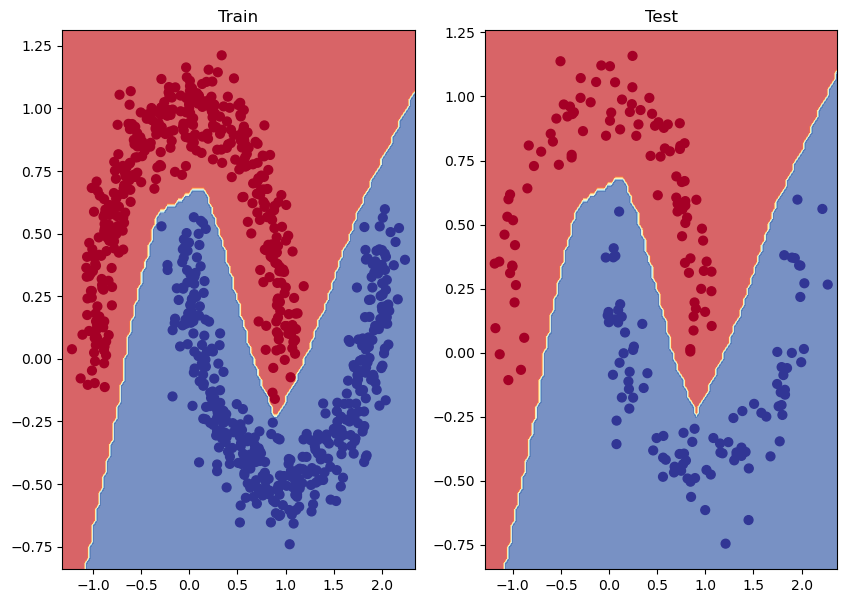

In [11]:
from helper_functions import plot_decision_boundary, plot_predictions
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model, X_test, y_test)

### 6. Create a multiclass dataset using the function provided below (from CS231n course).
* Construct a model capable of fitting your data
* Build a loss function and optimizer capable of handling multi-class data (optional: use the `Adam` optimizer instead of `SGD`, test different `lr` values)
* Make training and testing loop for the multi-class data and train model to reach 95% accuracy or better.
* Use `plot_decision_boundary()` to visualize the predictions

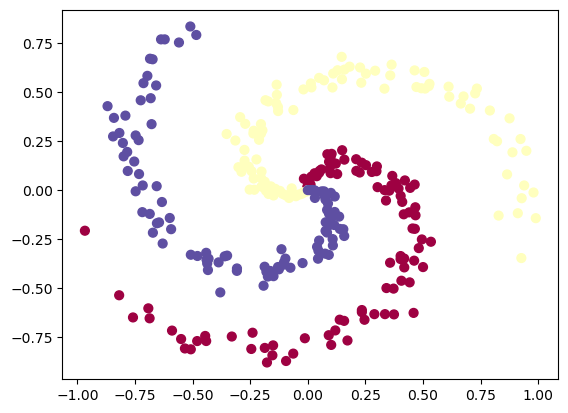

In [17]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [18]:
X.shape, y.shape

((300, 2), (300,))

In [19]:
X[:5], y[:5]

(array([[ 0.        ,  0.        ],
        [-0.0028473 ,  0.0096914 ],
        [-0.00119614,  0.02016658],
        [ 0.0119212 ,  0.02785962],
        [ 0.00635936,  0.03990044]]),
 array([0, 0, 0, 0, 0], dtype=uint8))

In [20]:
# Train/test split the data
X = torch.from_numpy(X).type(torch.float).to(device)
y = torch.from_numpy(y).type(torch.LongTensor).to(device)

X_train, X_test, y_train, y_test = train_test_split(X,
													y,
													test_size=TEST_SIZE,
													random_state=RANDOM_STATE)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([240, 2]),
 torch.Size([60, 2]),
 torch.Size([240]),
 torch.Size([60]))

In [26]:
# Create a model 
class SpiralPredictor(torch.nn.Module):
	def __init__(
			self,
			input_size: int = 2,
			output_size: int = 3,
			hidden_layers: int = 16):
		super().__init__()

		# Architecture 
		self.linear_relu_stack = torch.nn.Sequential(
			torch.nn.Linear(in_features=input_size, out_features=hidden_layers),
			torch.nn.ReLU(),
			torch.nn.Dropout(p=0.1),
			torch.nn.Linear(in_features=hidden_layers, out_features=hidden_layers),
			torch.nn.ReLU(),
			torch.nn.Linear(in_features=hidden_layers, out_features=output_size)
		)

	def forward(self, x):
		return self.linear_relu_stack(x)
	
model = SpiralPredictor().to(device)
model

SpiralPredictor(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): ReLU()
    (5): Linear(in_features=16, out_features=3, bias=True)
  )
)

In [27]:
# Loss / acc / optimizer
loss_fn = torch.nn.CrossEntropyLoss()

torchmetric_acc = Accuracy(task='multiclass',
					   num_classes=K).to(device)

optimizer = torch.optim.Adam(params=model.parameters(),
							 lr=0.01)

In [28]:
# Train / test loop
torch.manual_seed(RANDOM_STATE)
torch.mps.manual_seed(RANDOM_STATE)

EPOCHS = 300

for epoch in range(EPOCHS + 1):
	### TRAINING
	model.train()

	# Forward pass
	y_logits = model(X_train)
	y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

	# Loss / acc
	loss = loss_fn(y_logits, y_train)
	acc = torchmetric_acc(y_preds, y_train)

	# Zero grad
	optimizer.zero_grad()

	# Backward pass
	loss.backward()

	# Step
	optimizer.step()

	### TESTING
	model.eval()
	with torch.inference_mode():
		test_logits = model(X_test)
		test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

		test_loss = loss_fn(test_logits, y_test)
		test_acc = torchmetric_acc(test_preds, y_test)

	if epoch % 10 == 0:
		print(f"Epoch: {epoch} | Loss: {loss:.3f} | Acc: {acc*100:.2f}% | Test loss: {test_loss:.3f} | Test acc: {test_acc*100:.2f}%")

Epoch: 0 | Loss: 1.141 | Acc: 32.50% | Test loss: 1.126 | Test acc: 36.67%
Epoch: 10 | Loss: 1.011 | Acc: 50.42% | Test loss: 1.016 | Test acc: 48.33%
Epoch: 20 | Loss: 0.832 | Acc: 58.33% | Test loss: 0.816 | Test acc: 51.67%
Epoch: 30 | Loss: 0.715 | Acc: 61.67% | Test loss: 0.705 | Test acc: 51.67%
Epoch: 40 | Loss: 0.620 | Acc: 69.58% | Test loss: 0.616 | Test acc: 58.33%
Epoch: 50 | Loss: 0.530 | Acc: 73.33% | Test loss: 0.515 | Test acc: 71.67%
Epoch: 60 | Loss: 0.453 | Acc: 84.58% | Test loss: 0.425 | Test acc: 81.67%
Epoch: 70 | Loss: 0.402 | Acc: 83.33% | Test loss: 0.343 | Test acc: 86.67%
Epoch: 80 | Loss: 0.352 | Acc: 86.25% | Test loss: 0.276 | Test acc: 90.00%
Epoch: 90 | Loss: 0.302 | Acc: 90.00% | Test loss: 0.226 | Test acc: 91.67%
Epoch: 100 | Loss: 0.338 | Acc: 87.50% | Test loss: 0.195 | Test acc: 93.33%
Epoch: 110 | Loss: 0.275 | Acc: 87.50% | Test loss: 0.171 | Test acc: 96.67%
Epoch: 120 | Loss: 0.217 | Acc: 93.33% | Test loss: 0.146 | Test acc: 98.33%
Epoch: 130

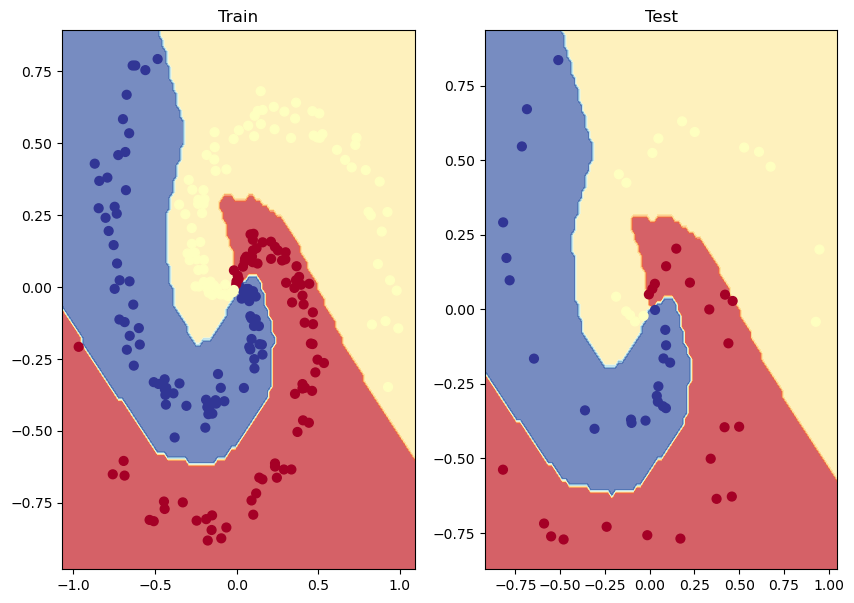

In [29]:
# Plot decision boundaries
plt.figure(figsize=(10, 7))

plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model, X_test, y_test)